# Partial dependence plots

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

import numpy as np
import xarray as xr
import pickle

2.2.0


In [2]:
tf.random.set_seed(1234)

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)

In [4]:
import seaborn as sns
sns.set_style('whitegrid')

In [5]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
import sklearn
from keras.wrappers.scikit_learn import KerasRegressor
import string

Using TensorFlow backend.


In [6]:
!ls saved_model_v9/

accretion_01_LcLr_sigm_16x16x16_big_n5
accretion_01_LcLr_sigm_16x16x16_big_n5_norm.pickle
accretion_01_LcLrXc_sigm_16x16x16_big_n5
accretion_01_LcLrXc_sigm_16x16x16_big_n5_norm.pickle
accretion_01_LcLrXcXrNu_sigm_16x16x16_big_n5
accretion_01_LcLrXcXrNu_sigm_16x16x16_big_n5_norm.pickle
accretion_01_LcLrXcXr_sigm_16x16x16_big_n5
accretion_01_LcLrXcXr_sigm_16x16x16_big_n5_norm.pickle
autocon_LcXc_01_sigm_16x16x16_big_n5_z12
autocon_LcXc_01_sigm_16x16x16_big_n5_z12_norm.pickle
autocon_LcXcNu_01_sigm_16x16x16_big_n5_z12
autocon_LcXcNu_01_sigm_16x16x16_big_n5_z12_norm.pickle
autocon_LcXcNuLr_01_sigm_16x16x16_big_n5_z12
autocon_LcXcNuLr_01_sigm_16x16x16_big_n5_z12_norm.pickle
autocon_LcXcNuTau_01_sigm_16x16x16_big_n5_z12
autocon_LcXcNuTau_01_sigm_16x16x16_big_n5_z12_norm.pickle
autoL2nu_XcTau_01_sigm_16x16x16_big_n5_z12
autoL2nu_XcTau_01_sigm_16x16x16_big_n5_z12_norm.pickle
autoL2_XcNuTau_01_sigm_16x16x16_big_n5_z12
autoL2_XcNuTau_01_sigm_16x16x16_big_n5_z12_norm.pickle
selfcloud_01_LcNcNu_si

## Accretion

In [7]:
keras_model = keras.models.load_model('saved_model_v9/accretion_01_LcLrXcXrNu_sigm_16x16x16_big_n5/')

In [8]:
normed_train_data = pd.read_csv('accretion_01_normed_train_data3.csv')
normed_val_data = pd.read_csv('accretion_01_normed_val_data3.csv')
normed_test_data = pd.read_csv('accretion_01_normed_test_data3.csv')
train_labels = pd.read_csv('accretion_01_train_labels3.csv')
val_labels = pd.read_csv('accretion_01_val_labels3.csv')
test_labels = pd.read_csv('accretion_01_test_labels3.csv')

In [9]:
cols_acc = list(normed_test_data.columns)

In [10]:
with open('saved_model_v9/accretion_01_LcLrXcXrNu_sigm_16x16x16_big_n5_norm.pickle', 'rb') as f:
    norm_acc = pickle.load(f)

In [11]:
def make_model():
    model = keras_model
    model.compile(keras.optimizers.SGD(0.), 'mse')
    return model

In [12]:
def compute_pdp(keras_model, normed_test_data):
    def make_model():
        model = keras_model
        model.compile(keras.optimizers.SGD(0.), 'mse')
        return model
    est = KerasRegressor(make_model)
    # Necessary for some dumb reason
    est.fit(normed_test_data[:2].values, np.ones((2, 1)))
    est._estimator_type = 'regressor'
    est.dummy_ = 'stupid'
    pdps = []
    vals = []
    for feature in normed_test_data:
        pdp, v = partial_dependence(est, normed_test_data[::20], feature, grid_resolution=100)
        pdps.append(pdp[0]); vals.append(v[0])
    return pdps, vals

In [14]:
def plot_pdp(pdps, vals, norm, ylabel, samey=False, exp=False, axs=None):
    if exp:
        miny = np.min([np.min(np.exp(pdp)) for pdp in pdps]); maxy = np.max([np.max(np.exp(pdp)) for pdp in pdps])
        miny = 0.5*miny; maxy=1.5*maxy
    else:
        miny = np.min([np.min(pdp) for pdp in pdps]); maxy = np.max([np.max(pdp) for pdp in pdps])
    if axs is None: fig, axs = plt.subplots(1, 5, figsize=(10, 2.3))
    for i, (pdp, v, ax, f) in enumerate(zip(pdps, vals, axs, normed_test_data.columns)):
        vv = v * norm.T[f]['std'] + norm.T[f]['mean']
        if exp: 
            if f != 'nu':
                vv = np.exp(vv)
            pdp = np.exp(pdp)
        ax.plot(vv, pdp, lw=2.5, c='navy')
        ax.set_xlabel(f)
        ax.set_title(f'{string.ascii_lowercase[i]})')
        if samey: ax.set_ylim(miny, maxy)
        if exp: 
            ax.set_xscale('log')
            ax.set_yscale('log')
    axs[0].set_ylabel(ylabel)
    if axs is None: plt.tight_layout(w_pad=0.8)
    return axs

In [15]:
pdps_acc, vals_acc = compute_pdp(keras_model, normed_test_data)

1/1 [==============================] - 0s 2ms/step - loss: 1151.4558


In [16]:
def acc_sb2001(Lc, Lr, use_phi=False):
    kr = 5.78
    tau = Lc/(Lc+Lr)
    if use_phi:
        phi = (tau/(tau+5e-4))**4
    else:
        phi = 1.
    acc = kr*Lc*Lr*phi
    return acc

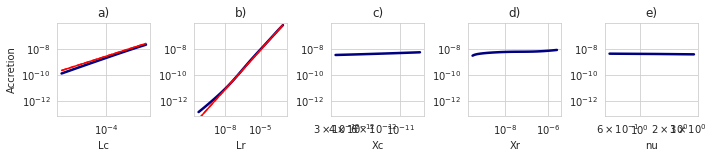

In [18]:
axs = plot_pdp(pdps, vals, norm, 'Accretion', samey=True, exp=True)
v=vals[0]; f='Lc'
vv = v * norm.T[f]['std'] + norm.T[f]['mean']
vv = np.exp(vv)
acc = acc_sb2001(vv, np.exp(norm['mean']['Lr']), True)
axs[0].plot(vv, acc, c='r')
acc = acc_sb2001(vv, np.exp(norm['mean']['Lr']))
axs[0].plot(vv, acc, c='r', ls='--')
v=vals[1]; f='Lr'
vv = v * norm.T[f]['std'] + norm.T[f]['mean']
vv = np.exp(vv)
acc = acc_sb2001(np.exp(norm['mean']['Lc']), vv, True)
axs[1].plot(vv, acc, c='r');
acc = acc_sb2001(np.exp(norm['mean']['Lc']), vv)
axs[1].plot(vv, acc, c='r', ls='--');

## Autocon

In [17]:
keras_model = keras.models.load_model('saved_model_v9/autocon_LcXcNuTau_01_sigm_16x16x16_big_n5_z12/')

In [18]:
normed_test_data = pd.read_csv('autocon_01_normed_test_data3.csv')
test_labels = pd.read_csv('autocon_01_test_labels3.csv')

In [19]:
cols_au = list(normed_test_data.columns)

In [20]:
with open('saved_model_v9/autocon_LcXcNuTau_01_sigm_16x16x16_big_n5_z12_norm.pickle', 'rb') as f:
    norm_au = pickle.load(f)

In [21]:
pdps_au, vals_au = compute_pdp(keras_model, normed_test_data)

1/1 [==============================] - 0s 2ms/step - loss: 786.4810


In [22]:
def au_sb2001(Lc, Xc, tau, nu):
    kc = 9.44e9
    xstar = 2.6e-10
    phi = 600*tau**0.68*(1-tau**0.68)**3
    au = kc/20/xstar * (nu+2) * (nu+4) / (nu+1)**2 *Lc**2 * Xc**2 * (1+phi/(1-tau)**2)
    return au

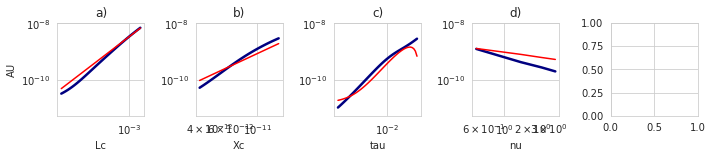

In [265]:
axs = plot_pdp(pdps, vals, norm, 'AU', samey=True, exp=True)

v=vals[0]; f='Lc'
vv = v * norm.T[f]['std'] + norm.T[f]['mean']
vv = np.exp(vv)
au = au_sb2001(vv, np.exp(norm['mean']['Xc']), np.exp(norm['mean']['tau']), np.exp(norm['mean']['nu']))
axs[0].plot(vv, au, c='r')

v=vals[1]; f='Xc'
vv = v * norm.T[f]['std'] + norm.T[f]['mean']
vv = np.exp(vv)
au = au_sb2001(np.exp(norm['mean']['Lc']), vv, np.exp(norm['mean']['tau']), np.exp(norm['mean']['nu']))
axs[1].plot(vv, au, c='r')

v=vals[2]; f='tau'
vv = v * norm.T[f]['std'] + norm.T[f]['mean']
vv = np.exp(vv)
au = au_sb2001(np.exp(norm['mean']['Lc']), np.exp(norm['mean']['Xc']), vv, np.exp(norm['mean']['nu']))
axs[2].plot(vv, au, c='r')

v=vals[3]; f='nu'
vv = v * norm.T[f]['std'] + norm.T[f]['mean']
au = au_sb2001(np.exp(norm['mean']['Lc']), np.exp(norm['mean']['Xc']), np.exp(norm['mean']['tau']), vv)
axs[3].plot(vv, au, c='r')

## Selfcloud

In [23]:
keras_model = keras.models.load_model('saved_model_v9/selfcloud_01_LcXcNuTau_sigm_16x16x16_big_n5/')

In [24]:
normed_test_data = pd.read_csv('selfcloud_01_normed_test_data4.csv')
test_labels = pd.read_csv('selfcloud_01_test_labels4.csv')

In [25]:
cols_scc = list(normed_test_data.columns)

In [26]:
with open('saved_model_v9/selfcloud_01_LcXcNuTau_sigm_16x16x16_big_n5_norm.pickle', 'rb') as f:
    norm_scc = pickle.load(f)

In [27]:
pdps_scc, vals_scc = compute_pdp(keras_model, normed_test_data)

1/1 [==============================] - 0s 1ms/step - loss: 32.2867


In [28]:
def scc_sb2001(Lc, nu):
    kc = 9.44e9
    scc = kc * (nu+2) / (nu+1) * Lc**2
    return scc

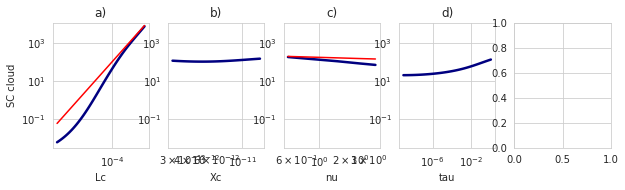

In [41]:
axs = plot_pdp(pdps_scc, vals_scc, norm, 'SC cloud', samey=True, exp=True)
v=vals_scc[0]; f='Lc'
vv = v * norm.T[f]['std'] + norm.T[f]['mean']
vv = np.exp(vv)
scc = scc_sb2001(vv, np.exp(norm['mean']['nu']))
axs[0].plot(vv, scc, c='r')


v=vals_scc[2]; f='nu'
vv = v * norm.T[f]['std'] + norm.T[f]['mean']
scc = scc_sb2001(np.exp(norm['mean']['Lc']), vv)
axs[2].plot(vv, scc, c='r');



## Selfrain

In [29]:
keras_model = keras.models.load_model('saved_model_v9/selfrain_01_LrXr_sigm_16x16x16_big_n5/')

In [30]:
normed_test_data = pd.read_csv('selfrain_01_normed_test_data1.csv')
test_labels = pd.read_csv('selfrain_01_test_labels1.csv')

In [31]:
cols_scr = list(normed_test_data.columns)

In [32]:
with open('saved_model_v9/selfrain_01_LrXr_sigm_16x16x16_big_n5_norm.pickle', 'rb') as f:
    norm_scr = pickle.load(f)

In [33]:
pdps_scr, vals_scr = compute_pdp(keras_model, normed_test_data)

1/1 [==============================] - 0s 2ms/step - loss: 261.3852


In [34]:
def scr_sb2001(Lr, Xr):
    kr = 5.78
    sc = kr*Lr**2/Xr
    return sc

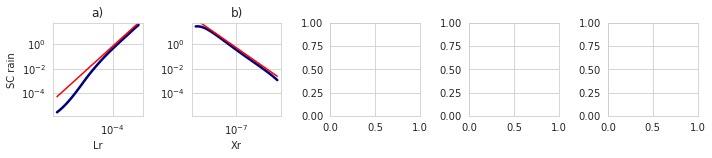

In [230]:
axs = plot_pdp(pdps, vals, norm, 'SC rain', samey=True, exp=True)
v=vals[0]; f='Lr'
vv = v * norm.T[f]['std'] + norm.T[f]['mean']
vv = np.exp(vv)
sc = sc_sb2001(vv, np.exp(norm['mean']['Xr']))
axs[0].plot(vv, sc, c='r')
v=vals[1]; f='Xr'
vv = v * norm.T[f]['std'] + norm.T[f]['mean']
vv = np.exp(vv)
sc = sc_sb2001(np.exp(norm['mean']['Lr']), vv)
axs[1].plot(vv, sc, c='r');

## Final figure

In [78]:
def plot_pdp(pdps, vals, norm, ylabel=None, samey=False, exp=False, axs=None):
    if exp:
        miny = np.min([np.min(np.exp(pdp)) for pdp in pdps]); maxy = np.max([np.max(np.exp(pdp)) for pdp in pdps])
        miny = 0.5*miny; maxy=1.5*maxy
    else:
        miny = np.min([np.min(pdp) for pdp in pdps]); maxy = np.max([np.max(pdp) for pdp in pdps])
    if axs is None: fig, axs = plt.subplots(1, 5, figsize=(10, 2.3))
    for i, (pdp, v, ax, f) in enumerate(zip(pdps, vals, axs, norm.T.columns)):
        vv = v * norm.T[f]['std'] + norm.T[f]['mean']
        if exp: 
            if f != 'nu':
                vv = np.exp(vv)
            pdp = np.exp(pdp)
        ax.plot(vv, pdp, lw=4, c='navy', label='Neural network')
#         ax.set_xlabel(f)
#         ax.set_title(f'{string.ascii_lowercase[i]})')
        if samey: ax.set_ylim(miny, maxy)
        if exp: 
            if f != 'nu':
                ax.set_xscale('log')
            ax.set_yscale('log')
    if ylabel is not None: axs[0].set_ylabel(ylabel)
    if axs is None: plt.tight_layout(w_pad=0.8)
    return axs

In [36]:
cols_acc

['Lc', 'Lr', 'Xc', 'Xr', 'nu']

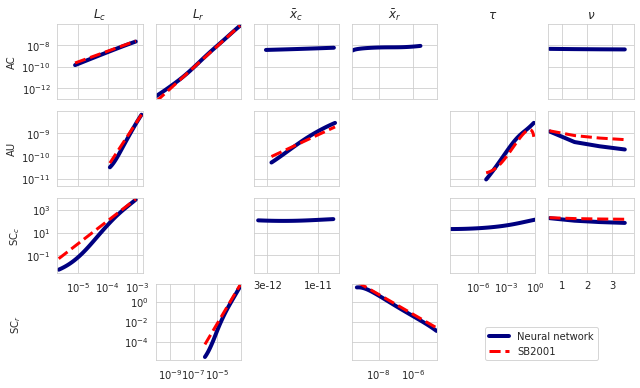

In [97]:
fig, axs = plt.subplots(4, 6, figsize=(9, 5.5))

col_order =['Lc', 'Lr', 'Xc', 'Xr', 'tau', 'nu']
col_names =[r'$L_c$', r'$L_r$', r'$\bar{x}_c$', r'$\bar{x}_r$', r'$\tau$', r'$\nu$']

# Accretion
axx = [axs[0, col_order.index(v)] for v in cols_acc]
[ax.axis('off') for v, ax in zip(col_order, axs[0]) if v not in cols_acc]

plot_pdp(pdps_acc, vals_acc, norm_acc, samey=True, exp=True, axs=axx)
    
v=vals_acc[0]; f='Lc'
vv = v * norm_acc.T[f]['std'] + norm_acc.T[f]['mean']
vv = np.exp(vv)
acc = acc_sb2001(vv, np.exp(norm_acc['mean']['Lr']), True)
axx[0].plot(vv, acc, c='r', lw=3, ls='--')
# acc = acc_sb2001(vv, np.exp(norm_acc['mean']['Lr']))
# axx[0].plot(vv, acc, c='r', ls='--', lw=3, ls='--')
v=vals_acc[1]; f='Lr'
vv = v * norm_acc.T[f]['std'] + norm_acc.T[f]['mean']
vv = np.exp(vv)
acc = acc_sb2001(np.exp(norm_acc['mean']['Lc']), vv, True)
axx[1].plot(vv, acc, c='r', lw=3, ls='--');
# acc = acc_sb2001(np.exp(norm_acc['mean']['Lc']), vv)
# axx[1].plot(vv, acc, c='r', ls='--', lw=3, ls='--');


# Autoconversion
axx = [axs[1, col_order.index(v)] for v in cols_au]
[ax.axis('off') for v, ax in zip(col_order, axs[1]) if v not in cols_au]

plot_pdp(pdps_au, vals_au, norm_au, samey=True, exp=True, axs=axx)

v=vals_au[0]; f='Lc'
vv = v * norm_au.T[f]['std'] + norm_au.T[f]['mean']
vv = np.exp(vv)
au = au_sb2001(vv, np.exp(norm_au['mean']['Xc']), np.exp(norm_au['mean']['tau']), np.exp(norm_au['mean']['nu']))
axx[0].plot(vv, au, c='r', lw=3, ls='--')

v=vals_au[1]; f='Xc'
vv = v * norm_au.T[f]['std'] + norm_au.T[f]['mean']
vv = np.exp(vv)
au = au_sb2001(np.exp(norm_au['mean']['Lc']), vv, np.exp(norm_au['mean']['tau']), np.exp(norm_au['mean']['nu']))
axx[1].plot(vv, au, c='r', lw=3, ls='--')

v=vals_au[2]; f='tau'
vv = v * norm_au.T[f]['std'] + norm_au.T[f]['mean']
vv = np.exp(vv)
au = au_sb2001(np.exp(norm_au['mean']['Lc']), np.exp(norm_au['mean']['Xc']), vv, np.exp(norm_au['mean']['nu']))
axx[2].plot(vv, au, c='r', lw=3, ls='--')

v=vals_au[3]; f='nu'
vv = v * norm_au.T[f]['std'] + norm_au.T[f]['mean']
au = au_sb2001(np.exp(norm_au['mean']['Lc']), np.exp(norm_au['mean']['Xc']), np.exp(norm_au['mean']['tau']), vv)
axx[3].plot(vv, au, c='r', lw=3, ls='--')


# SC C
axx = [axs[2, col_order.index(v)] for v in cols_scc]
[ax.axis('off') for v, ax in zip(col_order, axs[2]) if v not in cols_scc]

plot_pdp(pdps_scc, vals_scc, norm_scc, samey=True, exp=True, axs=axx)

v=vals_scc[0]; f='Lc'
vv = v * norm_scc.T[f]['std'] + norm_scc.T[f]['mean']
vv = np.exp(vv)
scc = scc_sb2001(vv, np.exp(norm_scc['mean']['nu']))
axx[0].plot(vv, scc, c='r', lw=3, ls='--')

v=vals_scc[2]; f='nu'
vv = v * norm_scc.T[f]['std'] + norm_scc.T[f]['mean']
scc = scc_sb2001(np.exp(norm_scc['mean']['Lc']), vv)
axx[2].plot(vv, scc, c='r', lw=3, ls='--');



# SC R
axx = [axs[3, col_order.index(v)] for v in cols_scr]
[ax.axis('off') for v, ax in zip(col_order, axs[3]) if v not in cols_scr]

plot_pdp(pdps_scr, vals_scr, norm_scr, samey=True, exp=True, axs=axx)

v=vals_scr[0]; f='Lr'
vv = v * norm_scr.T[f]['std'] + norm_scr.T[f]['mean']
vv = np.exp(vv)
sc = scr_sb2001(vv, np.exp(norm_scr['mean']['Xr']))
axx[0].plot(vv, sc, c='r', lw=3, ls='--')

v=vals_scr[1]; f='Xr'
vv = v * norm_scr.T[f]['std'] + norm_scr.T[f]['mean']
vv = np.exp(vv)
sc = scr_sb2001(np.exp(norm_scr['mean']['Lr']), vv)
axx[1].plot(vv, sc, c='r', lw=3, ls='--', label='SB2001');

[ax.set_title(c) for ax, c in zip(axs[0], col_names)]
[ax.set_ylabel(v) for ax, v in zip(axs[:, 0], [r'AC', r'AU', r'SC$_c$', r'SC$_r$'])]

plt.tight_layout()

for i, v in enumerate(col_order):
    minx = []; maxx = []
    for c, val, norm in zip(
        [cols_acc, cols_au, cols_scc, cols_scr], 
        [vals_acc, vals_au, vals_scc, vals_scr],
        [norm_acc, norm_au, norm_scc, norm_scr]
    ):
        try:
            idx = c.index(v)
            vv = val[idx] * norm.T[v]['std'] + norm.T[v]['mean']
#             print(vv)
            if not v == 'nu':
                vv = np.exp(vv)
#             print(vv)
            minx.append(np.min(vv)); maxx.append(np.max(vv))
        except:
            pass
    minx = np.min(minx)*0.9; maxx = np.max(maxx)*1.1
#     print(v, minx, maxx)
    
    [ax.set_xlim(minx, maxx) for ax in axs[:, i]]
    
#Ticks

[ax.set_xticks([1e-5, 1e-4, 1e-3]) for ax in axs[:, 0]]
[ax.set_xticks([1e-9, 1e-7, 1e-5]) for ax in axs[:, 1]]
[ax.set_xticks([1e-8, 1e-6]) for ax in axs[:, 3]]
[ax.set_xticks([1e-6, 1e-3, 1e-0]) for ax in axs[:, 4]]
[ax.set_xticks([1, 2, 3]) for ax in axs[:, 5]]

[ax.set_yticks([1e-8, 1e-10, 1e-12]) for ax in axs[0]]
[ax.set_yticks([1e-9, 1e-10, 1e-11]) for ax in axs[1]]
[ax.set_yticks([1e3, 1e1, 1e-1]) for ax in axs[2]]
[ax.set_yticks([1e0, 1e-2, 1e-4]) for ax in axs[3]]
    

[ax.set_xticks([], minor=True) for ax in axs[:, 2]]
[ax.set_xticks([3e-12, 1e-11], minor=False) for ax in axs[:, 2]]
[ax.set_xticklabels([3e-12, 1e-11]) for ax in axs[:, 2]]

[ax.set_xticklabels([]) for ax in np.concatenate([
    axs[0], axs[1]
])]
[ax.set_yticklabels([]) for ax in np.concatenate([
    axs[:, 2:].flat, axs[:3, 1]
])]
plt.subplots_adjust(wspace=0.15, hspace=0.15)

axs[3, 3].legend(bbox_to_anchor=(1.5, 0.5))

axs[-1, 0].text(-.00086, 0.4, r'SC$_r$', rotation=90)

fig.savefig('PDP.pdf', bbox_inches='tight')

In [52]:
ax.text()

<a list of 5 Text major ticklabel objects>

In [126]:
v = 'Lc'

In [127]:
cols_scr.index(v)

ValueError: 'Lc' is not in list

In [132]:
minx = []; maxx = []
for c, val in zip([cols_acc, cols_au, cols_scc, cols_scr], [vals_acc, vals_au, vals_scc, vals_scr]):
    try:
        idx = c.index(v)
        vv = val[idx]
        if not v == 'nu':
            vv = np.exp(vv)
        minx.append(np.min(vv)); maxx.append(np.max(vv))
    except:
        pass

[3.2285550893544377, 6.153439572007582, 2.9834508734046272]

In [89]:
col_order

['Lc', 'Lr', 'Xc', 'Xr', 'tau', 'nu']

In [94]:
cols_acc, cols_au, cols_scc, cols_scr

(['Lc', 'Lr', 'Xc', 'Xr', 'nu'],
 ['Lc', 'Lr', 'Xc', 'Xr', 'nu'],
 ['Lc', 'Xc', 'nu', 'tau'],
 ['Lr', 'Xr'])

## To save in other notebooks

In [266]:
# Save data for PDP notebook
normed_train_data3.to_csv('accretion_01_normed_train_data3.csv', index=False)
normed_val_data3.to_csv('accretion_01_normed_val_data3.csv', index=False)
normed_test_data3.to_csv('accretion_01_normed_test_data3.csv', index=False)
train_labels3.to_csv('accretion_01_train_labels3.csv', index=False)
val_labels3.to_csv('accretion_01_val_labels3.csv', index=False)
test_labels3.to_csv('accretion_01_test_labels3.csv', index=False)